# Trabalho Final

Alguns pontos essenciais da apresentação:

1. Apresentação da análise do Problema
2. Apresentação da análise e tratamento dos dados
3. Justificativa do uso de técnicas de IA para Resolução do problema
4. Justificativa da escolha do ambiente de desenvolvimento, teste e uso
5. Apresentação da metodologia da solução com uso de IA
6. Aplicação das técnicas de Inteligência Artificial no seu problema
7. Estratégias para obtenção de resultados melhores para solução do prooblema
8. Análise dos resultados            
9. Conclusões
10. Trabalhos futuros

Alguns critérios de Avaliações:

a) O problema ou dados foram analisados pensando-se na solução com uso de IA?
b) A solução apresentada tem fundamento? Justifica-se com os conceitos da IA?
c) A ambiente para desenvolvimento da solução faz uso das ferramentas atuais? Considera soluções atuais apresentadas pela comunidade científica e de desenvolvimento?
d) A solução apresentada buscou aproveitar, ao máximo, a técnica de IA? Houve preocupação em ajustar parâmetros para solução?
e) A análise foi feita de forma adequada?
f) Pensou em como seria o uso efetivo da sua solução?


## Bibliotecas

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 999)
pd.set_option("display.max_rows", 999)
np.set_printoptions(threshold=np.inf)

from PIL import Image, ImageFilter

import os, shutil
from pathlib import Path
import random

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import set_random_seed
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2

SEED = 42
# set_random_seed(SEED)
np.random.seed(SEED)

BASE_PATH = Path.cwd().parent
PRE_PATH = BASE_PATH / 'data' / 'pre'
# BASE_PATH = '../input/cap-ia-data'

## Conexão Google Drive

In [105]:
# # Mount Google Drive 
# from google.colab import drive
# drive.mount('/content/drive')

## Carregamento das imagens

In [106]:
grid_map = {
    '64_32':64,
    '64_48':64,
    '128_64':128,
    '256_128':256
}

spatial_res_map = {
    '2m':2,
    '1m':1,
    '05m': 0.5
}

In [107]:
def get_images(imgs_dir, imgs_names, img_size, crop_size):
    """
    Inputs:
        imgs_dir: path to the images directory
        imgs_names: list of images names
        img_size: size of the images
        crop_size: size of the crop
    Outputs:
        imgs_resized: list of images resized and cropped
    """
    img_shape = (img_size, img_size)
    crop_shape = (crop_size, crop_size, img_size-crop_size, img_size-crop_size)
    imgs = [Image.open(imgs_dir / img_name) for img_name in imgs_names]
    imgs_resized = [img.resize(img_shape).crop(crop_shape) for img in imgs]

    return imgs_resized

In [108]:
def imgs_to_array(imgs):
    # print(imgs[:10])
    img_array = np.stack([np.asarray(img) for img in imgs], axis=0)
    # print(img_array.shape)
    return img_array

In [109]:
def get_labels(spatial_res, grid, dataset, threshold=0.05, samples=None, positive_only=False, balance_classes=False):
    img_size = int(grid_map[grid] / spatial_res_map[spatial_res])
    crop_size = 1
    imgs_dir = Path(PRE_PATH, 'Labels', spatial_res, grid, dataset)
    imgs_names = [name for name in os.listdir(imgs_dir) if name[-3:] == 'jpg']
    imgs = get_images(imgs_dir, imgs_names, img_size, crop_size)
    imgs_array = imgs_to_array(imgs)
    labels = imgs_array.sum(axis=1).sum(axis=1) / (img_size^2) > threshold
    labels = labels.astype(int)
    
    if positive_only:
        pos_idx = np.where(labels >= 1)[0]
        imgs_names = [imgs_names[idx] for idx in pos_idx]
        labels = labels[pos_idx]
    
    if balance_classes:
        pos_idx = np.where(labels >= 1)[0]
        neg_idx = np.where(labels == 0)[0]
        pos_names = [imgs_names[idx] for idx in pos_idx]
        samples_neg = np.random.choice(np.arange(len(neg_idx)), size=len(pos_idx), replace=False)
        neg_names = [imgs_names[idx] for idx in samples_neg]
        imgs_names = pos_names + neg_names
        labels = np.concatenate([labels[pos_idx], labels[samples_neg]])

    if samples is not None:
        samples_idx = np.random.choice(np.arange(len(labels)), samples, replace=False)
        imgs_names = [imgs_names[idx] for idx in samples_idx]
        labels = labels[samples_idx]
        
    return imgs_names, labels

In [110]:
def plot_images(spatial_res, grid, dataset, positive=True, samples=5, sources=None):
    names, labels = get_labels(spatial_res, grid, dataset, 0.05, samples, positive)
    img_size = int(grid_map[grid] / spatial_res_map[spatial_res])
    if sources == None:
        sources = ['CBERS_234', 'CBERS_321', 'CBERS_432', 'Labels', 'Google']

    src_imgs = []
    for source in sources:
        if source == 'Google':
            imgs = get_images(Path(PRE_PATH, source, '03m', grid, dataset), names, int(grid_map[grid] / 0.3), 1)
        else:
            imgs = get_images(Path(PRE_PATH, source, spatial_res, grid, dataset), names, img_size, 1)

        src_imgs.append(imgs)

    fig, axs = plt.subplots(len(src_imgs), samples, figsize=(12, samples*2.5))
    for i, imgs in zip(range(len(src_imgs)), src_imgs):
        for j in range(samples):
            axs[i, j].imshow(imgs[j])
            axs[i, j].title.set_text(names[j])
    plt.tight_layout()
    plt.show()
    return names, labels


In [111]:
df = pd.DataFrame(columns=['spatial_res', 'grid', 'dataset', 'imgs', 'pos', '%pos'])

for spatial_res in ['2m']:
    for grid in ['64_48']:
        for dataset in ['Train', 'Test']:
            _, labels = get_labels(spatial_res, grid, dataset)
            df = pd.concat([df, 
                            pd.DataFrame({'spatial_res':[spatial_res],
                                          'grid':[grid],
                                          'dataset':[dataset],
                                          'imgs':[labels.shape[0]],
                                          'pos':[labels.sum()]},)], ignore_index=True)

df['%pos'] = df.pos / df.imgs    
df.head(100)

,spatial_res,grid,dataset,imgs,pos,%pos
0,2m,64_48,Train,2611,216,0.082727
1,2m,64_48,Test,556,91,0.163669


## Inspeção visual

### Dataset Treino - Amostras Positivas

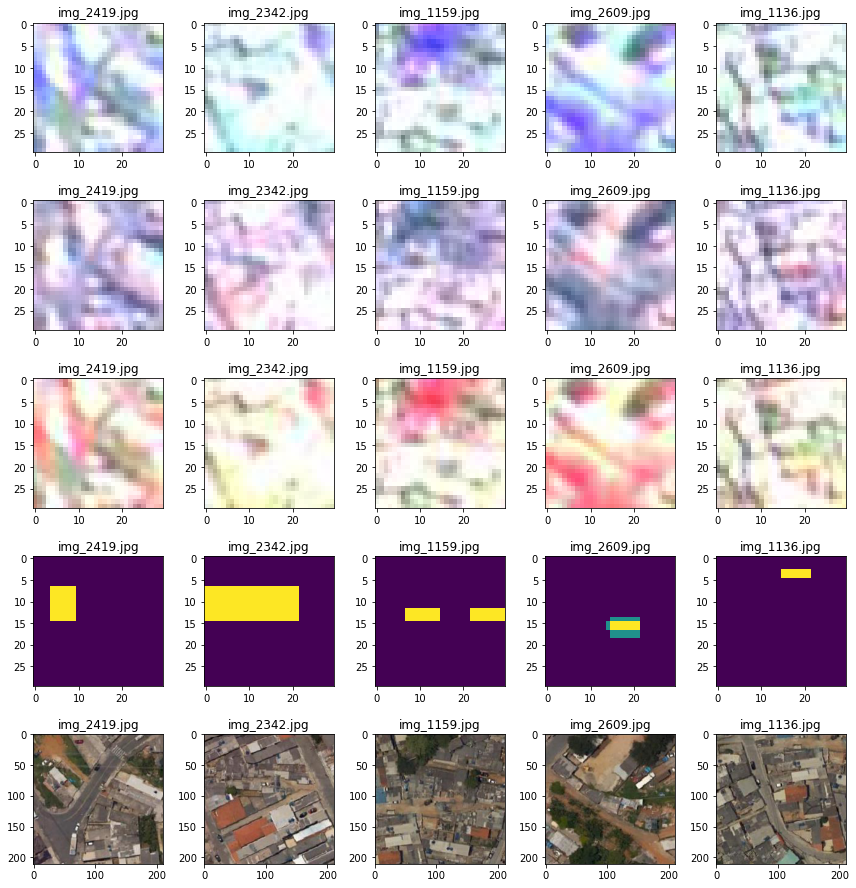

In [112]:
names, labels = plot_images('2m', '64_48', 'Train')

### Dataset Treino - Amostras Negativas

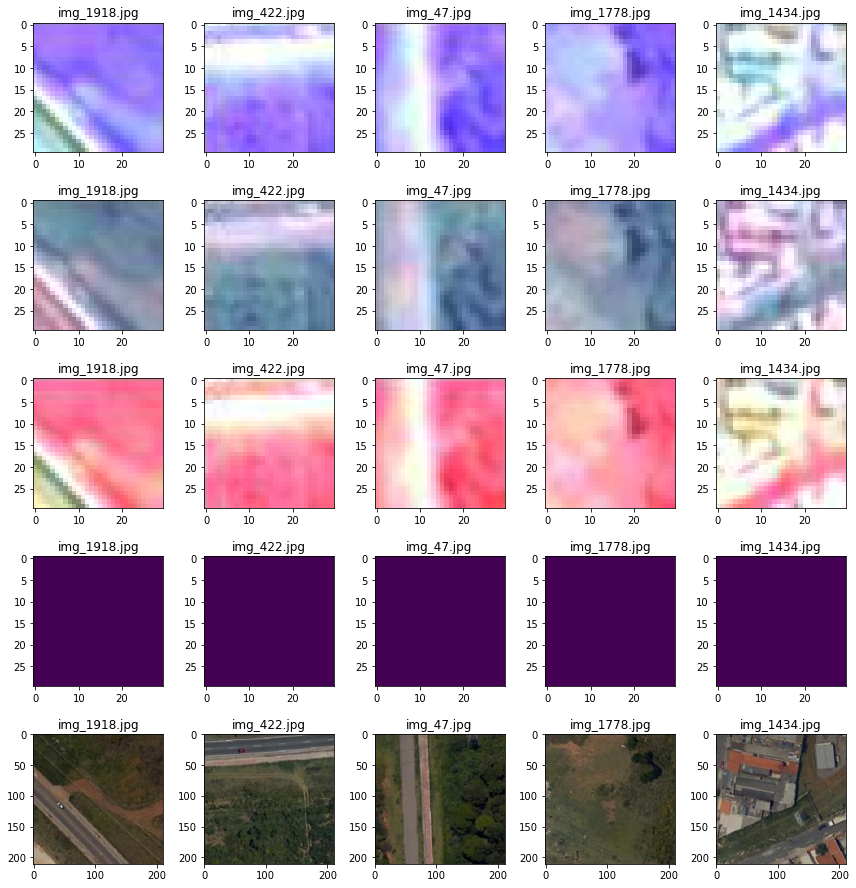

In [113]:
names, labels = plot_images('2m', '64_48', 'Train', False, 5)

### Dataset Teste - Amostras Positivas

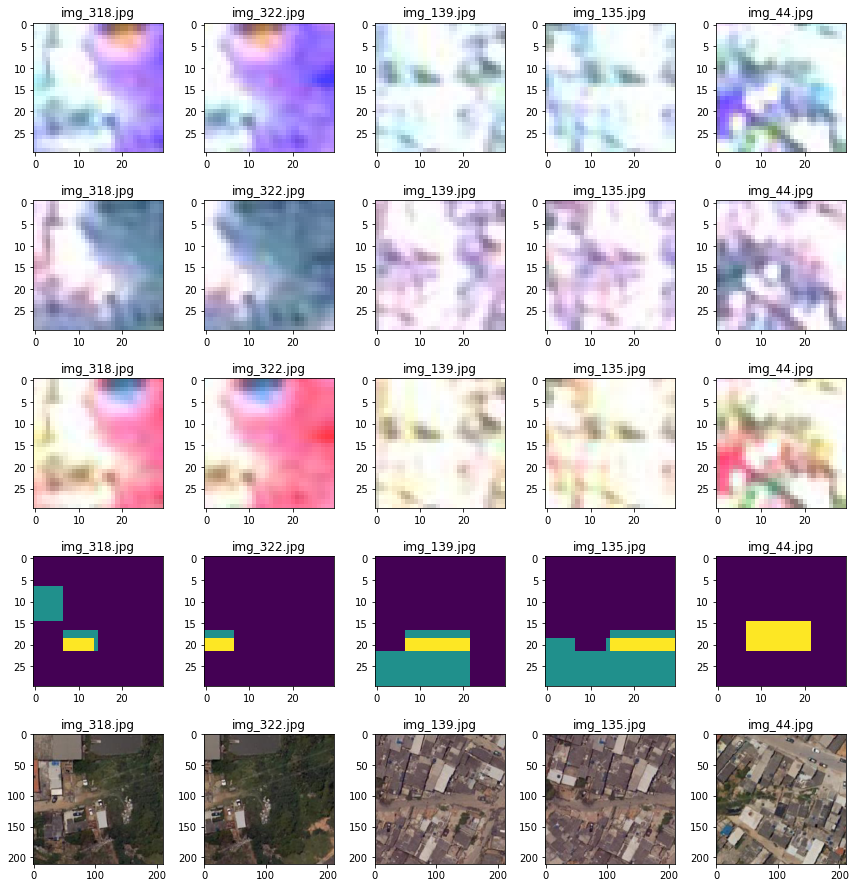

In [114]:
names, labels = plot_images('2m', '64_48', 'Test')

### Dataset Teste - Amostras Negativas

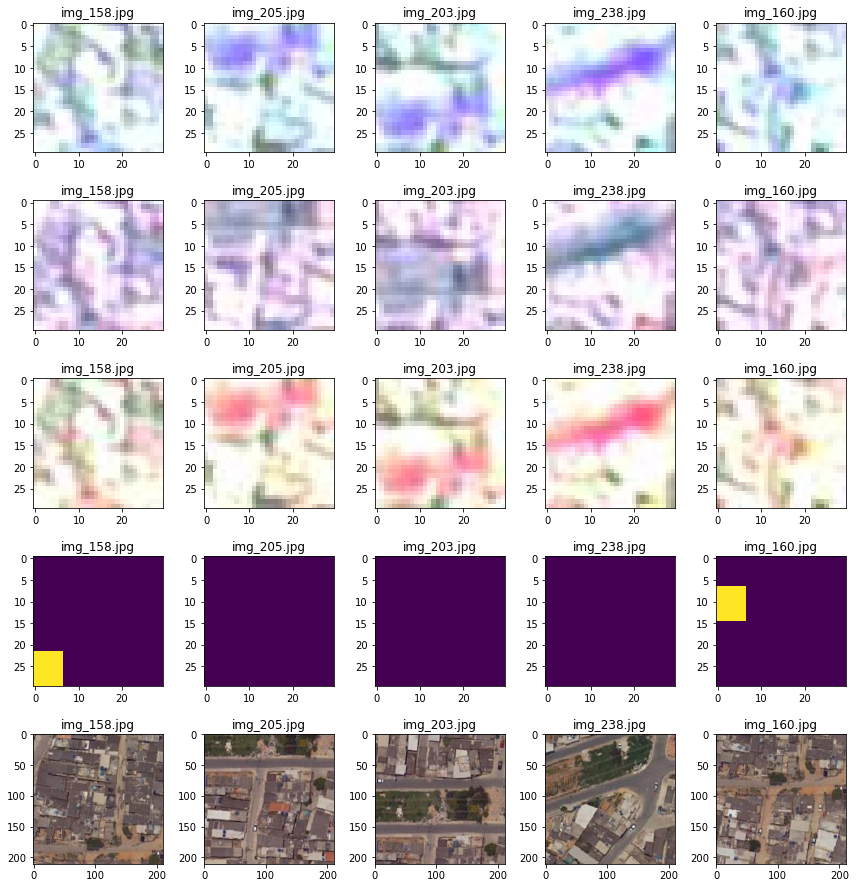

In [115]:
names, labels = plot_images('2m', '64_48', 'Test', False, 5)

## Criando a Rede Neural Convolucional

In [116]:
def build_model(size, plot=False):
    inputs = keras.Input(shape=(size, size, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=2, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=4, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=8, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, kernel_regularizer=l2(0.001), activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    if plot:
        plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)
    return model

## Preparando Dados de Treino e Teste

In [117]:
def make_train_test(source, spatial_res, grid, only_train=False):
    img_size = int(grid_map[grid] / spatial_res_map[spatial_res])
    train_names, y_train = get_labels(spatial_res, grid, 'Train', 0.05, None, False, True)
    train_imgs = get_images(Path(PRE_PATH, source, spatial_res, grid, 'Train'), train_names, img_size, 1)
    X_train = imgs_to_array(train_imgs)

    if only_train == False:
        test_names, y_test = get_labels(spatial_res, grid, 'Test', 0.05, None, False, False)
        test_imgs = get_images(Path(PRE_PATH, source, spatial_res, grid, 'Test'), test_names, img_size, 1)
        X_test = imgs_to_array(test_imgs)
    else:
        y_test = None
        X_test = None
    
    return X_train, y_train, X_test, y_test

## Treinando o modelo com validação cruzada

In [118]:
from sklearn.model_selection import StratifiedKFold

def train_model_kfold(source, spatial_res, grid, n_splits=5, num_epochs=100, batch_size=16):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    X_train, y_train, _, _ = make_train_test(source, spatial_res, grid, True)
    
    img_size = grid_map[grid] / spatial_res_map[spatial_res]
    img_size = int(img_size) - 2

    all_loss, all_val_loss, all_acc, all_val_acc = [], [], [], []
    fold = 0

    for train_idx, val_idx in kfold.split(X_train, y_train):
        
        X_train_fold = X_train[train_idx].copy()
        y_train_fold = y_train[train_idx].copy()
        
        X_val_fold = X_train[val_idx].copy()
        y_val_fold = y_train[val_idx].copy()
        
        if fold==0:
            model = build_model(img_size, plot=True)
        else:
            model = build_model(img_size)

        
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=num_epochs, batch_size=batch_size, verbose=0)
        
        # loss
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        all_loss.append(loss)
        all_val_loss.append(val_loss)

        # accuracy
        acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]
        all_acc.append(acc)
        all_val_acc.append(val_acc)

        print('Fold {}: Train Loss {:0.3f} | Train Acc {:0.3f}'.format(fold,
                                                                    loss[-1],
                                                                    acc[-1]))
        print('Fold {}: Val   Loss {:0.3f} | Val   Acc {:0.3f}'.format(fold,
                                                                    val_loss[-1],
                                                                    val_acc[-1]))
        fold += 1
        
    results = {
        'all_loss': all_loss,
        'all_val_loss': all_val_loss,
        'all_acc': all_acc,
        'all_val_acc': all_val_acc
    }
    return results

In [119]:
def plot_results(results):
    all_loss = results['all_loss']
    all_val_loss = results['all_val_loss']
    all_acc = results['all_acc']
    all_val_acc = results['all_val_acc']

    num_epochs = len(all_loss[0])

    average_loss_history = [
        np.mean([x[i] for x in all_loss]) for i in range(num_epochs)]

    average_val_loss_history = [
        np.mean([x[i] for x in all_val_loss]) for i in range(num_epochs)]

    average_acc_history = [
        np.mean([x[i] for x in all_acc]) for i in range(num_epochs)]

    average_val_acc_history = [
        np.mean([x[i] for x in all_val_acc]) for i in range(num_epochs)]

    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, average_loss_history, "bo", label="Training loss")
    plt.plot(epochs, average_val_loss_history, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print()
    plt.plot(epochs, average_acc_history, "bo", label="Training accuracy")
    plt.plot(epochs, average_val_acc_history, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [120]:
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score

def avalia_modelo(y, p, title):

    TN, FP, FN, TP = confusion_matrix(y, p).ravel()
    # f1 = f1_score(y, p)
    f2 = fbeta_score(y, p, beta=2)
    # MCC = matthews_corrcoef(y, p)
    acc = accuracy_score(y, p)
    print()
    print('#-----------------------------< ' + title + ' >-----------------------------#')
    print("n = {}\t\t\tPredicted Positive \tPredicted Negative".format(p.shape[0]))
    print("Actually Positive\t\t{} \t\t\t{}".format(TP, FN))
    print("Actually Negative\t\t{} \t\t\t{}".format(FP, TN))
    print()
    print('Acc', acc)
    # print("f1", f1)
    print("f2", f2)
    # print("MCC", MCC)
#     print("#-------------------------------------------------------------------------#")

    scores = {
        "TN":TN,
        "FP":FP,
        "FN":FN,
        "TP":TP,
        # "f1":f1,
        "f2":f2,
        # "MCC":MCC
    }
  
    return scores

In [121]:
from sklearn.metrics import classification_report

def evaluate_model(source, spatial_res, grid, num_epochs=100, batch_size=16):
    X_train, y_train, X_test, y_test = make_train_test(source, spatial_res, grid, False)
    img_size = grid_map[grid] / spatial_res_map[spatial_res]
    img_size = int(img_size) - 2

    model = build_model(img_size)
    history = model.fit(X_train, y_train,
                        epochs=num_epochs, batch_size=batch_size, verbose=0)

    train_preds = np.round(model.predict(X_train), 0)
    test_preds = np.round(model.predict(X_test), 0)

    avalia_modelo(y_train, train_preds, 'Train')
    avalia_modelo(y_test, test_preds, 'Test')
    

In [122]:
def complete_experiment(source, spatial_res, grid, num_epochs=100, batch_size=16):
    results = train_model_kfold(source, spatial_res, grid, 5, num_epochs, batch_size)
    plot_results(results)
    evaluate_model(source, spatial_res, grid, num_epochs, batch_size)

## Experimentos - CBERS_234

Fold 0: Train Loss 0.431 | Train Acc 0.809
Fold 0: Val   Loss 0.462 | Val   Acc 0.793
Fold 1: Train Loss 0.429 | Train Acc 0.812
Fold 1: Val   Loss 0.537 | Val   Acc 0.736
Fold 2: Train Loss 0.435 | Train Acc 0.809
Fold 2: Val   Loss 0.492 | Val   Acc 0.779
Fold 3: Train Loss 0.382 | Train Acc 0.835
Fold 3: Val   Loss 0.668 | Val   Acc 0.640
Fold 4: Train Loss 0.419 | Train Acc 0.815
Fold 4: Val   Loss 0.821 | Val   Acc 0.558


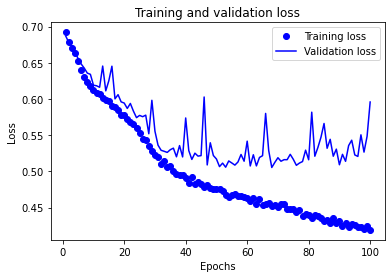

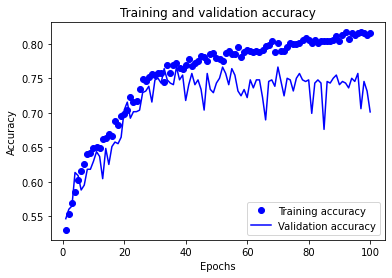

18/18 [==============================] - 0s 3ms/step

#-----------------------------< Train >-----------------------------#
n = 432			Predicted Positive 	Predicted Negative
Actually Positive		216 			12
Actually Negative		78 			126

Acc 0.7916666666666666
f2 0.8955223880597014

#-----------------------------< Test >-----------------------------#
n = 556			Predicted Positive 	Predicted Negative
Actually Positive		78 			13
Actually Negative		201 			264

Acc 0.6151079136690647
f2 0.6065318818040435


In [123]:
complete_experiment('CBERS_234', '2m', '64_48')

## Experimentos - CBERS_321

Fold 0: Train Loss 0.339 | Train Acc 0.875
Fold 0: Val   Loss 0.562 | Val   Acc 0.759
Fold 1: Train Loss 0.691 | Train Acc 0.530
Fold 1: Val   Loss 0.691 | Val   Acc 0.529
Fold 2: Train Loss 0.423 | Train Acc 0.801
Fold 2: Val   Loss 0.416 | Val   Acc 0.826
Fold 3: Train Loss 0.386 | Train Acc 0.829
Fold 3: Val   Loss 0.519 | Val   Acc 0.686
Fold 4: Train Loss 0.457 | Train Acc 0.780
Fold 4: Val   Loss 0.445 | Val   Acc 0.791


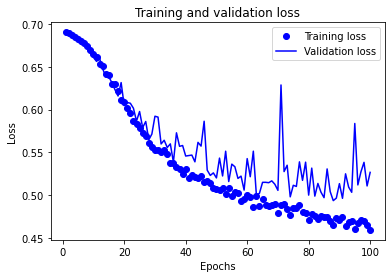

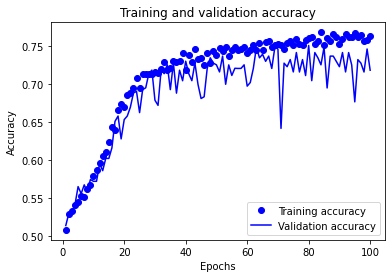

18/18 [==============================] - 0s 2ms/step

#-----------------------------< Train >-----------------------------#
n = 432			Predicted Positive 	Predicted Negative
Actually Positive		220 			11
Actually Negative		49 			152

Acc 0.8611111111111112
f2 0.9220452640402345

#-----------------------------< Test >-----------------------------#
n = 556			Predicted Positive 	Predicted Negative
Actually Positive		80 			11
Actually Negative		128 			337

Acc 0.75
f2 0.6993006993006993


In [124]:
complete_experiment('CBERS_321', '2m', '64_48')

## Experimentos - CBERS_432

Fold 0: Train Loss 0.413 | Train Acc 0.826
Fold 0: Val   Loss 0.664 | Val   Acc 0.701
Fold 1: Train Loss 0.478 | Train Acc 0.757
Fold 1: Val   Loss 0.455 | Val   Acc 0.793
Fold 2: Train Loss 0.399 | Train Acc 0.827
Fold 2: Val   Loss 0.515 | Val   Acc 0.756
Fold 3: Train Loss 0.436 | Train Acc 0.801
Fold 3: Val   Loss 0.416 | Val   Acc 0.826
Fold 4: Train Loss 0.413 | Train Acc 0.818
Fold 4: Val   Loss 0.672 | Val   Acc 0.733


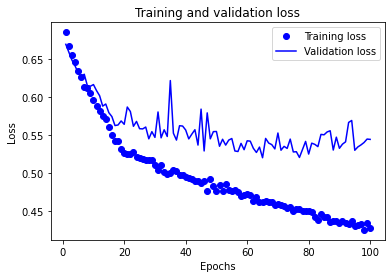

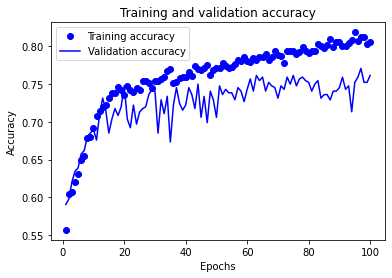

18/18 [==============================] - 0s 2ms/step

#-----------------------------< Train >-----------------------------#
n = 432			Predicted Positive 	Predicted Negative
Actually Positive		219 			16
Actually Negative		61 			136

Acc 0.8217592592592593
f2 0.8975409836065573

#-----------------------------< Test >-----------------------------#
n = 556			Predicted Positive 	Predicted Negative
Actually Positive		79 			12
Actually Negative		168 			297

Acc 0.6762589928057554
f2 0.646481178396072


In [125]:
complete_experiment('CBERS_432', '2m', '64_48')

## Experimentos - Google 2m

In [126]:
# complete_experiment('Google', '2m', '64_48')

## Experimentos - Google 0,5m

In [127]:
# complete_experiment('Google', '05m', '64_48')